# Ideas

- Sentiment analisys
- POS tagging
- Similarity (spaCy)
- Vis
    - word trees
    - bubble chart (top words)
    - [scattertext][2]
- Text Mining and Visualization [book][3]
- Applied Text Mining in Python on [coursera][4]

[2]: https://github.com/JasonKessler/scattertext
[3]: https://www.google.ru/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwja1azlqpDXAhVkOpoKHTR-DKQQFggpMAA&url=https%3A%2F%2Fdoc.lagout.org%2FOthers%2FData%2520Mining%2FText%2520Mining%2520and%2520Visualization_%2520Case%2520Studies%2520using%2520Open-Source%2520Tools%2520%255BHofmann%2520%2526%2520Chisholm%25202015-12-18%255D.pdf&usg=AOvVaw192OqWLftT7fQpwWxMaLSh
[4]: https://www.coursera.org/learn/python-text-mining/home/week/4

# EDA

## import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
sns.set()
pd.options.display.max_colwidth = 160

## Load data

In [2]:
train = pd.read_csv('data/train.zip')
test  = pd.read_csv('data/test.zip')

sample_submission = pd.read_csv('data/sample_submission.zip')

In [3]:
sample_submission.head(1)

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698


In [4]:
display(train.shape, test.shape)

(19579, 3)

(8392, 2)

In [188]:
train.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set ...",EAP
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL


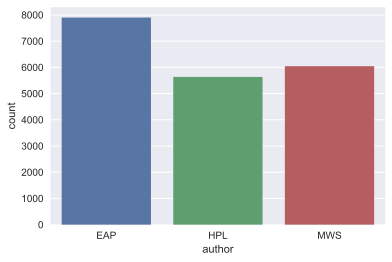

In [189]:
sns.countplot(x=train.author);

# Preprocessing

In [5]:
import spacy
import nltk

In [6]:
nlp = spacy.en.English()

In [7]:
spacy.en.STOP_WORDS.add("'s")
for word in spacy.en.STOP_WORDS:
    lexeme = nlp.vocab[word]
    lexeme.is_stop = True

In [8]:
# def replace_ents(text):
#     prefix = 'ent__'
#     doc = nlp(text)
#     for ent in doc.ents:
#         text = text.replace(ent.orth_, prefix + ent.label_)
#     return text

In [13]:
def preprocess(df):
    print('Started')
    doc = df.text.apply(nlp)
    print('Text parsed')
    
    df['n_char']   = df.text.apply(len)
    df['n_sents']  = doc.apply(lambda x: len(list(x.sents)))
    df['n_ents']   = doc.apply(lambda x: len(x.ents))
    df['n_chunks'] = doc.apply(lambda x: len(list(x.noun_chunks)))
    df['n_punct']  = doc.apply(lambda x: len([t for t in x if t.is_punct]))
    df['n_words']  = doc.apply(lambda x: len([t for t in x if not t.is_punct]))
    df['n_unique_words'] = doc.apply(lambda x: len(set([t.lower_ for t in x if not t.is_punct])))
    df['n_stop_words']   = doc.apply(lambda x: len([t for t in x if t.is_stop]))
    df['mean_word_len']  = doc.apply(lambda x: np.mean([len(t.orth_) for t in x if not t.is_punct]))
    df['word_by_sent']   = df['n_words'] / df['n_sents']
    df['char_by_sent']   = df['n_char']  / df['n_sents']
    df['punct_by_sent']  = df['n_punct'] / df['n_sents']
    print('Features created')
    
    #df.text = df.text.apply(replace_ents)
    #print('Entities replaced')
    
    df['text_lemmatized'] = doc.apply(lambda x: ' '.join([t.lemma_ for t in x if not t.is_punct]))
    df['text_cleaned_lemmatized'] = doc.apply(lambda x: ' '.join([t.lemma_ for t in x if not t.is_punct and not t.is_stop]))
    print('Text cleaned')

In [14]:
%%time
preprocess(train)

Started
Text parsed
Features created
Text cleaned
CPU times: user 31.8 s, sys: 294 ms, total: 32.1 s
Wall time: 32.4 s


In [64]:
%%time
preprocess(test)

Started
Text parsed
Features created
Text cleaned
CPU times: user 14.2 s, sys: 864 ms, total: 15.1 s
Wall time: 15.4 s


In [15]:
fd = nltk.FreqDist([y for x in train.text_cleaned.str.split() for y in x])

## vis

In [16]:
eap = train[train.author=='EAP'].text_cleaned
hpl = train[train.author=='HPL'].text_cleaned
mws = train[train.author=='MWS'].text_cleaned

In [17]:
fd_eap = nltk.FreqDist([y for x in eap.str.split() for y in x])
fd_hpl = nltk.FreqDist([y for x in hpl.str.split() for y in x])
fd_mws = nltk.FreqDist([y for x in mws.str.split() for y in x])

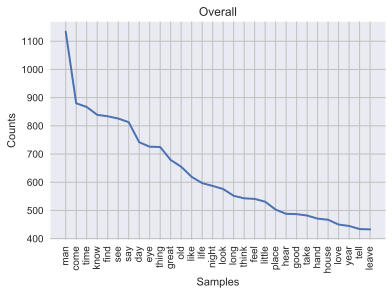

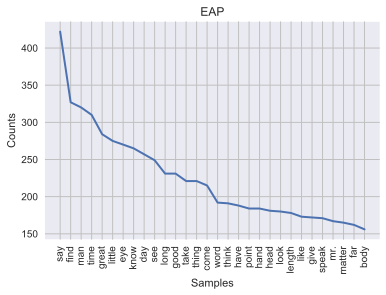

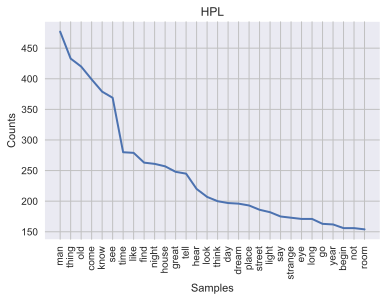

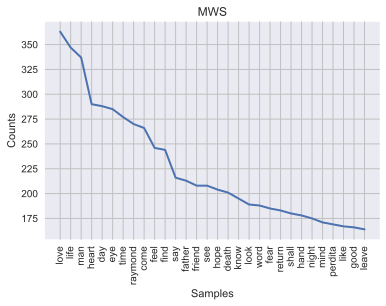

In [18]:
fd.plot(30, title='Overall')
fd_eap.plot(30, title='EAP')
fd_hpl.plot(30, title='HPL')
fd_mws.plot(30, title='MWS')

### Word Clouds

In [19]:
from wordcloud import WordCloud
sns.set_style('whitegrid', {'axes.grid' : False})

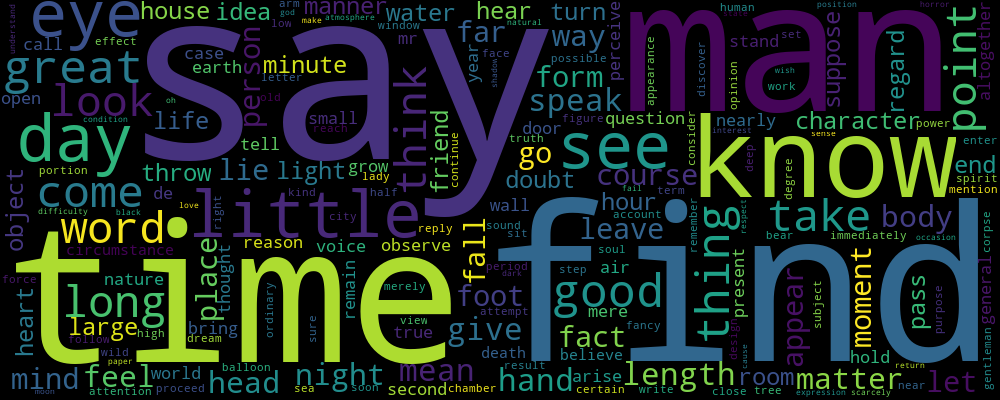

In [105]:
WordCloud(min_font_size=8, width=1000, height=400).generate(' '.join(eap)).to_image()

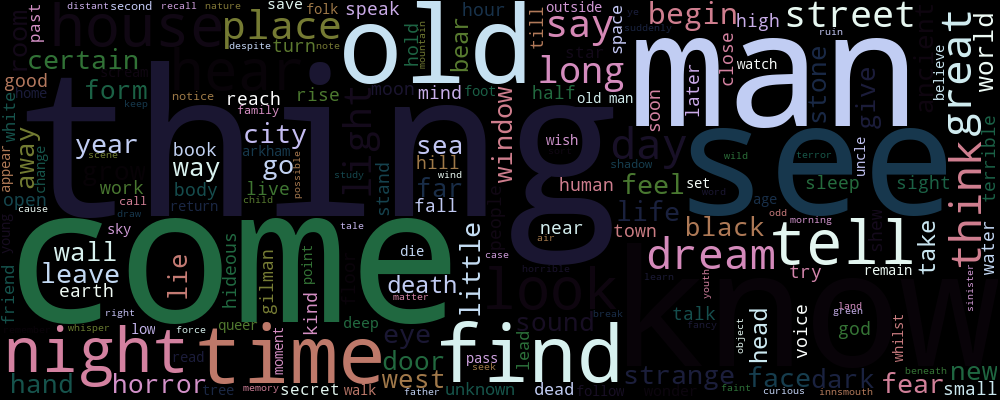

In [106]:
WordCloud(min_font_size=8, width=1000, height=400, colormap='cubehelix_r').generate(' '.join(hpl)).to_image()

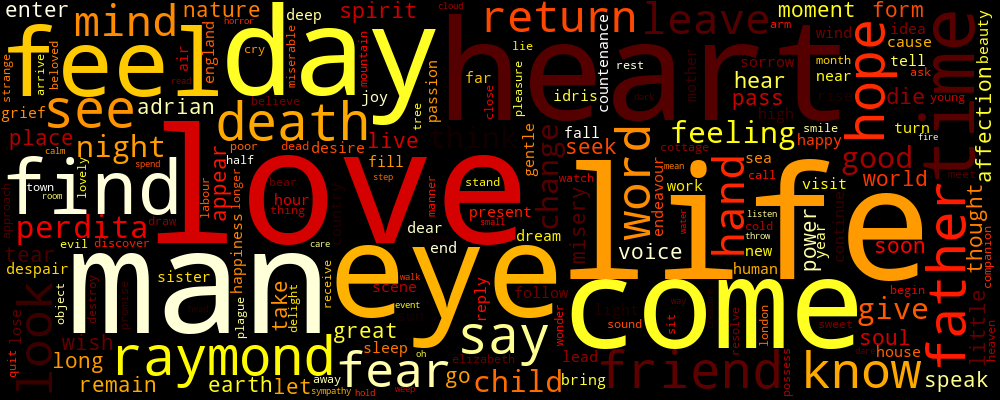

In [107]:
WordCloud(min_font_size=8, width=1000, height=400, colormap='hot').generate(' '.join(mws)).to_image()

In [20]:
vocab = [x[0] for x in fd.most_common(3000)]

In [21]:
clean = lambda x: ' '.join([q for q in x.split() if q in vocab])

In [22]:
train.text_cleaned = train.text_cleaned.apply(clean)

# Models

In [80]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

In [75]:
vectorizer = CountVectorizer()

In [76]:
vectorizer.fit(train.text_cleaned.append(test.text_cleaned))
X = vectorizer.transform(train.text_cleaned)
y = train.author

In [77]:
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.548 +- 0.034


In [78]:
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.566 +- 0.037


In [87]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3))
vectorizer.fit(train.text.append(test.text))
X = vectorizer.transform(train.text)

In [88]:
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.523 +- 0.025


In [89]:
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.443 +- 0.035


In [98]:
vectorizer = CountVectorizer(ngram_range=(1,7), analyzer='char')
vectorizer.fit(train.text.append(test.text))
X = vectorizer.transform(train.text)

In [102]:
scores = cross_val_score(LogisticRegression(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.495 +- 0.080


In [103]:
scores = cross_val_score(MultinomialNB(), X, y, cv=10, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 3.675 +- 0.433


In [57]:
import xgboost as xgb
import lightgbm as lgb

In [58]:
lgbc = lgb.LGBMClassifier(objective='multiclass', n_estimators=100)

In [ ]:
scores = cross_val_score(lgbc, X, y, cv=4, n_jobs=-1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

In [32]:
X_meta = train.drop(['id', 'text', 'author', 'text_cleaned'], axis=1)

In [84]:
scores = cross_val_score(LogisticRegression(), X_meta, y, cv=10, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.965 +- 0.015


In [86]:
scores = cross_val_score(MultinomialNB(), X_meta, y, cv=10, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 1.034 +- 0.026


In [33]:
xgbc = xgb.XGBClassifier(
    n_estimators=450, 
    objective='multi:softprob',
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.3,
)

In [ ]:
%%time
scores = cross_val_score(xgbc, X_meta.drop(['n_sents'], axis=1), y, cv=4, n_jobs=4, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

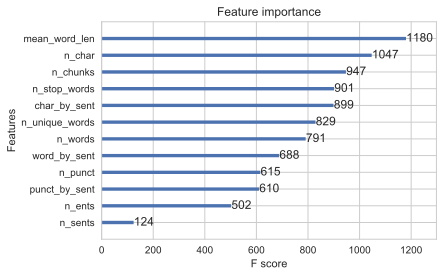

In [35]:
xgbc.fit(X_meta, y);
xgb.plot_importance(xgbc);

In [60]:
X = pd.concat([X_meta, pd.DataFrame(X.toarray())], axis=1)

In [61]:
X.shape

(19579, 2999)

In [62]:
scores = cross_val_score(MultinomialNB(), X, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.552 +- 0.030


In [63]:
scores = cross_val_score(LogisticRegression(), X, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.550 +- 0.074


In [90]:
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [233]:
def add_prob_features(vectorizer, col, model, prefix, cv=5):
    vectorizer.fit(train[col].append(test[col]))
    X = vectorizer.transform(train[col])
    X_test = vectorizer.transform(test[col])
    
    cv_scores = []
    pred_test = 0
    pred_train = np.zeros([train.shape[0], 3])
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=123)
    
    print('CV started')
    for train_index, dev_index in kf.split(X, y):
        X_train, X_dev = X[train_index], X[dev_index]
        y_train, y_dev = y[train_index], y[dev_index]
        
        model.fit(X_train, y_train)
        pred_dev   = model.predict_proba(X_dev)
        pred_test += model.predict_proba(X_test)
    
        pred_train[dev_index, :] = pred_dev
        cv_scores.append(metrics.log_loss(y_dev, pred_dev))
        print('.', end='')
        
    print('')
    print("Mean CV LogLoss: %.3f" % (np.mean(cv_scores)))
    pred_test /= cv

    train[prefix+"eap"] = pred_train[:, 0]
    train[prefix+"hpl"] = pred_train[:, 1]
    train[prefix+"mws"] = pred_train[:, 2]
    
    test[prefix+"eap"] = pred_test[:, 0]
    test[prefix+"hpl"] = pred_test[:, 1]
    test[prefix+"mws"] = pred_test[:, 2]

In [152]:
add_prob_features(TfidfVectorizer(), 'text_cleaned', MultinomialNB(), 'nb_tfidf_', cv=40)

Mean CV LogLoss: 0.612


In [153]:
add_prob_features(CountVectorizer(), 'text', MultinomialNB(), 'nb_cnt_', cv=40)

Mean CV LogLoss: 0.449


In [232]:
add_prob_features(CountVectorizer(ngram_range=(1,7), analyzer='char'), 'text', LogisticRegression(), 'lr_chcnt_')

CV started
.....Mean CV LogLoss: 0.506


In [234]:
X_meta = train.drop(['id', 'text', 'author', 'text_cleaned'], axis=1)

In [241]:
%%time
scores = cross_val_score(xgbc, X_meta.drop(['n_sents'], axis=1), y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.3f +- %.3f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.353 +- 0.020
CPU times: user 30.3 s, sys: 3 s, total: 33.3 s
Wall time: 12.1 s


CPU times: user 9.45 s, sys: 717 ms, total: 10.2 s
Wall time: 3.98 s


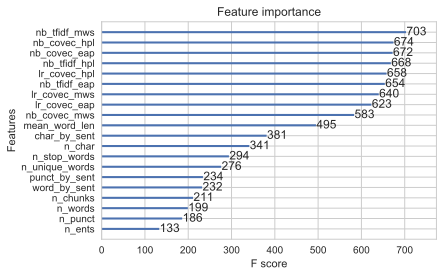

In [243]:
%%time
xgbc.fit(X_meta.drop(['n_sents'], axis=1), y);
xgb.plot_importance(xgbc);

In [245]:
test_id = test.id
out_df = pd.DataFrame(xgbc.predict_proba(test.drop(['id', 'text', 'text_cleaned', 'n_sents'], axis=1)))
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_xgb.csv", index=False)

In [219]:
lgbc = lgb.LGBMClassifier(objective='multiclass', n_estimators=65, num_leaves=10)

In [239]:
%%time
scores = cross_val_score(lgbc, X_meta, y, cv=4, n_jobs=1, scoring='neg_log_loss')
print('LogLoss: %.4f +- %.4f' % (-np.mean(scores), 2*np.std(scores)))

LogLoss: 0.3516 +- 0.0176
CPU times: user 2.74 s, sys: 1.09 s, total: 3.83 s
Wall time: 1.72 s


In [221]:
lgbc.fit(X_meta, y);

In [222]:
test_id = test.id
out_df = pd.DataFrame(lgbc.predict_proba(test.drop(['id', 'text', 'text_cleaned'], axis=1)))
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_lgb.csv", index=False)